<a href="https://colab.research.google.com/github/wdoppenberg/mp-operational-envelope/blob/master/OperationalEnvelope.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Current operational envelope

[Source](https://pdfs.semanticscholar.org/3407/0d83c8b6c77a0f95a16c444f4460dfe5e58c.pdf) 


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [0]:
def mdot(p, A_t, Gamma, R, T_c):
    """
    Mass flow function.

    Accepts type `np.array` for `p` and `T_c`
    """
    return (p*A_t*Gamma) / np.sqrt(R*T_c)

def p_t(V_0, p_0, m_exit_t, rho):
    """
    Pressure vs time function.
    """
    return (V_0 * p_0) / (V_0 + (m_exit_t/rho))


## Constant chamber temperature

| Variable         | Value               | Unit     | Description                                                                         |
|------------------|---------------------|----------|-------------------------------------------------------------------------------------|
| $A_t$            | $$4.5\cdot 10^{-9}$$  | m$^2$    | Nozzle throat area                                                                  |
| $l$              | $0.30$              | $m$      | Propellant tubing length                                                            |
| $R_{water}$      | $461.67$            | J/K/kg   | Gas constant water vapour                                                           |
| $\Gamma_{water}$ | $0.67$              | -        | Van der Kerckhoven constant water vapour                                            |
| $\rho_{water}$   | $997$               | kg/m$^3$ | Density liquid water                                                                |
| $d$              | $1.57\cdot 10^{-3}$ | m        | Inner diameter propellant tubing                                                    |
| $T_0$            | $283$               | K        | Ambient temperature in satellite                                                    |
| $h_{vap}$        | $2256$              | kJ/kg    | Heat of vapourization water vapour                                                  |
| $c_{p,l}$        | $4187$              | J/K/kg   | Specific heat of liquid water                                                       |
| $c_{p,v}$        | $1996$              | J/K/kg   | Specific heat of water vapour                                                       |
| $\Phi_N$         | $0.12$              | -        | Gaseous Nitrogen volume fraction of the initial propellant storage ($\sum\Phi_i=1$) |
| $p_{0,N}$        | $1.1$                 | bar      | Initial Nitrogen pressure                                                           |
| $p_{0,LPM}$      | $2\cdot 10^4$       | Pa       | LPM testing initial inlet pressure                                                  |
| $p_{LPM,req}$    | $270$                 | Pa       | Required pressure in the LPM plenum                                                 |
| $m_0$            | $0.5$                 | g        | Total initial propellant mass                                                       |
| $m_{0,LPM}$      | $0.2$                 | g        | LPM initial propellant mass                                                         |
| $\eta$           | $0.6 $                | -        | Total heating efficiency                                                            |
| $t_{VLM}$        | $1200$                | s        | VLM testing duration                                                                |
| $t_{LPM}$        | $200$                 | s        | LPM testing duration                                                                |


### Constants

In [0]:
# Time & timestep
dt = 0.1      #s
t_end = 2500    #s
t = np.arange(0, t_end, dt, dtype='f')

# Propellant properties
h = 2256e3      #J/kg
c_l = 4187      #J/K/kg liquid water
c_v = 1996      #J/K/kg water vapour
Gamma = 0.6712
R = 461.67      #J/K/kg
rho = 997       #kg/m^3
p_vap0 = 1e5
T_vap0 = 373
h_vap = 40e3
R_vap = 8.341

# Geometric & environmental properties
A_t = 4.5e-9    #m^2 
l = 0.30        #m
d = 1.57e-3     #m
T_0 = 283       #K
V_tube = (l*np.pi*(d**2))/4

### Simulate envelope

In [0]:
p_0 = np.arange(1., 2.2, 0.4)*1e5
T_c0 = h_vap*T_vap0/(T_vap0*R_vap*np.log(p_vap0/p_0)+h_vap)
m_0 = p_0*A_t*Gamma/(np.sqrt(R*T_c0))
V_0 = np.arange(0.05, 0.2, 0.05)*V_tube

sim_dim = (len(p_0), len(V_0), len(t))

m = np.zeros(sim_dim)
p = np.zeros(sim_dim)
temp = np.zeros(sim_dim)

m[:, :, 0], _ = np.meshgrid(m_0, V_0, indexing='ij')
p[:, :, 0], V_0 = np.meshgrid(p_0, V_0, indexing='ij')
p_0 = p[:, :, 0]

T_c = 600

for ii, _ in enumerate(t[1:], 1):
    p[:,:,ii] = V_0*p_0/(V_0+temp[:,:,ii-1])
    m[:,:,ii] = mdot(p[:,:,ii-1], A_t, Gamma, R, T_c)
    temp[:,:,ii] = temp[:,:,ii-1]+m[:,:,ii]*dt/rho

T_vap = h_vap*T_vap0/(T_vap0*R_vap*np.log(p_vap0/p)+h_vap)

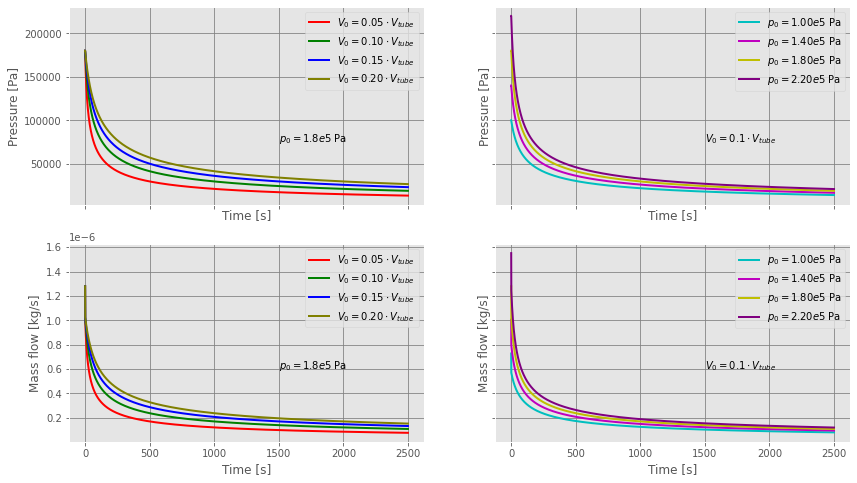

In [0]:
color = {
    'p_0': ['c', 'm', 'y', 'purple'],
    'V_0': ['r', 'g', 'b', 'olive']
}
plt.style.use('ggplot')

fig, ax = plt.subplots(2, 2, figsize=(14,8), sharex=True, sharey='row')

for i, p_i in enumerate(p[2,:,:]):
    ax[0, 0].plot(
        t, 
        p_i, 
        label=f'$V_0 = {V_0[0,i]/V_tube:.2f}\cdot V_{{tube}}$',
        color=color['V_0'][i],
        linewidth=2
    )

ax[0, 0].set_xlabel('Time [s]')
ax[0, 0].set_ylabel('Pressure [Pa]')
ax[0, 0].text(1500, 0.75e5, f'$p_0 = {p[2,0,0]/1e5:.1f}e5$ Pa')
ax[0, 0].ticklabel_format(axis="y", style="sci")
ax[0, 0].legend()
ax[0, 0].grid(color='grey')

for i, p_i in enumerate(p[:,1,:]):
    ax[0, 1].plot(
        t,
        p_i,
        label=f'$p_0 = {p[i,0,0]/1e5:.2f}e5$ Pa',
        color=color['p_0'][i],
        linewidth=2
    )

ax[0, 1].set_xlabel('Time [s]')
ax[0, 1].set_ylabel('Pressure [Pa]')
ax[0, 1].text(1500, 0.75e5, f'$V_0 = {V_0[1,1]/V_tube}\cdot V_{{tube}}$')
ax[0, 1].ticklabel_format(axis="y", style="sci")
ax[0, 1].legend()
ax[0, 1].grid(color='grey')

for i, p_i in enumerate(m[2,:,:]):
    ax[1, 0].plot(
        t,
        p_i,
        label=f'$V_0 = {V_0[0,i]/V_tube:.2f}\cdot V_{{tube}}$',
        color=color['V_0'][i],
        linewidth=2
    )

ax[1, 0].set_xlabel('Time [s]')
ax[1, 0].set_ylabel('Mass flow [kg/s]')
ax[1, 0].text(1500, 0.6e-6, f'$p_0 = {p[2,0,0]/1e5:.1f}e5$ Pa')
ax[1, 0].legend()
ax[1, 0].grid(color='grey')

for i, p_i in enumerate(m[:,1,:]):
    ax[1, 1].plot(
        t,
        p_i,
        label=f'$p_0 = {p[i,0,0]/1e5:.2f}e5$ Pa',
        color=color['p_0'][i],
        linewidth=2
    )

ax[1, 1].set_xlabel('Time [s]')
ax[1, 1].set_ylabel('Mass flow [kg/s]')
ax[1, 1].text(1500, 0.6e-6, f'$V_0 = {V_0[1,1]/V_tube}\cdot V_{{tube}}$')
ax[1, 1].legend()
ax[1, 1].grid(color='grey')

## Final operational envelope

In [0]:
dt = 0.1        #s
t_end = 1200    #s
t = np.arange(0, t_end, dt, dtype='f')

In [0]:
p_0 = 1.1e5
T_c0 = h_vap*T_vap0/(T_vap0*R_vap*np.log(p_vap0/p_0)+h_vap)
m_0 = p_0*A_t*Gamma/(np.sqrt(R*T_c0))
V_0 = 0.12*V_tube

sim_dim = t.shape

m = np.zeros(sim_dim)
p = np.zeros(sim_dim)
T_c = np.zeros(sim_dim)

m[0] = m_0
p[0] = p_0
T_c[0] = T_c0
temp = 0

for ii, _ in enumerate(t[1:], 1):
    p[ii] = V_0*p_0/(V_0+temp)
    m[ii] = mdot(p[ii-1], A_t, Gamma, R, T_c[ii-1])
    T_c[ii] = h_vap*T_vap0/(T_vap0*R_vap*np.log(p_vap0/p[ii-1])+h_vap)
    temp = temp+m[ii-1]*dt/rho

T_vap = h_vap*T_vap0/(T_vap0*R_vap*np.log(p_vap0/p)+h_vap)
Q = m * (T_c-T_0)*c_l + h*m
V_t = V_0 * (p_0 / p)
mass = (V_tube - V_t) * rho

I_sp = 74
g_0 = 9.81
F_t = m*I_sp*g_0

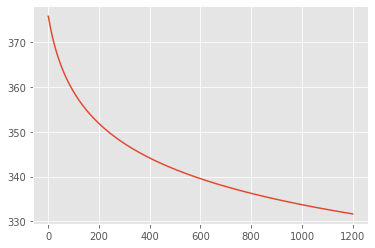

In [0]:
plt.plot(t, T_c)
#

# Corrections

## Ideal Rocket Theory - VLM

* [Experimental and Numerical Determination of Micropropulsion
Device Efficiencies at Low Reynolds Numbers](https://engineering.purdue.edu/~alexeenk/papers/aiaaj-05.pdf)
* [Experimental Study of Low
Reynolds Number Nozzles ](https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19870010950.pdf)

The above operational envelope calculations do not take into account impact of the boundary layer separation caused by low Reynolds numbers which often occur in microthrusters. 

From [[Makhan, 2019]](https://repository.tudelft.nl/islandora/object/uuid%3Aaaed2594-d414-4c83-967b-0cd94cccd23f):

"The nozzle discharge factor relates the experimental mass flow to the theoretical mass flow. It accounts for boundary layer effects and real gas effects (e.g. compressibility). The nozzle quality relates the experimental thrust coefficient to the theoretical thust coefficient. It accounts for losses due to friction effects, divergence and shifting gas composition. [[Suton & Biblarz]](http://mae-nas.eng.usu.edu/MAE_5540_Web/propulsion_systems/subpages/Rocket_Propulsion_Elements.pdf) [[Huzel and Huang]](https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19710019929.pdf) [[Spisz et al]](https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19650027295.pdf)."

$$ C_d = \frac{(A_t)_{eff}}{(A_t)_{ideal}} \approx \frac{\dot{m}_{exp}}{\dot{m}_{ideal}} $$

$$ \xi_F = \frac{(C_F)_{eff}}{(C_F)_{ideal}} = \frac{F(p_c\cdot A_t)^{-1}}{(C_F)_{ideal}}$$

$$ (C_F)_{ideal} = {C_F}^{\circ}  + \left( \frac{p_e}{p_c} - \frac{p_a}{p_c} \right) \cdot AR = \Gamma \cdot \sqrt{ \frac{2\gamma}{\gamma-1} \cdot \left( 1 - \left( \frac{p_e}{p_c}\right)^{\frac{\gamma-1}{\gamma}} \right)} + \left( \frac{p_e}{p_a} - \frac{p_a}{p_c} \right) \cdot \frac{A_e}{A_t}$$

$$ AR = \frac{A_e}{A_t} $$

$$ F = \dot{m}\cdot C_F \cdot c^* $$

$$ {C_F}^{\circ} = \frac{V_e}{c^{*}} $$

$$ \xi_s = \frac{(I_{sp})_{exp}}{(I_{sp})_{ideal}} $$

$$ \xi_b = \frac{(c^*)_{exp}}{(c^*)_{ideal}} = \frac{\xi_s}{\xi_F} $$

$$ Re = \frac{\dot{m}\cdot D_H}{\mu_t \cdot A_t} $$

$$ D_H = \frac{4A_t}{P_w} $$

$$ \frac{T_t}{T_{tot}} = \frac{\gamma + 1}{2} $$

## IRT Corrections - VLM

### Divergence loss

[[Farokhi]](https://www.wiley.com/en-us/Aircraft+Propulsion%2C+2nd+Edition-p-9781118806777)

$$ (C_F)_{div\_loss} = CA \cdot {C_F}^{\circ} + \left( \frac{p_e}{p_a} - \frac{p_a}{p_c} \right)\cdot AR$$

$$ CA_{2D-C} = \frac{\sin(\theta_{nd})}{\theta_{nd}}$$

$$ CA_{3D-C} = \frac{1+\cos(\theta_{nd})}{2}$$ 

* $C_A$: divergence loss factor [-]
* $\theta_{nd}$: nozzle divergence half angle [rad]
* 2D-C: 2D conical nozzle
* 3D-C: 3D conical nozzle


In [0]:
def C_F_divloss(CA, C_F0, p_e, p_a, p_c, AR):
    return CA*C_F0 + (p_e/p_a - p_a/p_c)*AR

def CA_2D(theta_nd):
    return np.sin(theta_nd)/theta_nd

def CA_3D(theta_nd):
    return (1+np.cos(theta_nd))/2

theta_nd = np.radians([10, 15, 20])
1-CA_3D(theta_nd)

array([0.00759612, 0.01703709, 0.03015369])

Verified using p.80 from [Zandbergen]

### Viscous loss

[[Spisz et al]](https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19650027295.pdf)

$$ (C_F)_{visc\_loss} = (C_F)_{ideal} - (C_F)_{visc} = (C_F)_{ideal} - \frac{17.6\cdot e^{0.0032\cdot AR}}{\sqrt{0.773Re}}$$

In [0]:
def C_F_visc(AR, Re):
    return (17.6 * np.exp(0.0032*AR))/np.sqrt(0.773*Re)

C_F0 = 1
AR = 10
Re = np.logspace(3, 7, 5)

C_F_visc(AR, Re)

array([0.65361249, 0.20669042, 0.06536125, 0.02066904, 0.00653612])

Verified using p. 86 from [Zandbergen]

### Throat boundary layer loss

[[Tang and Fenn]](https://arc.aiaa.org/doi/abs/10.2514/3.60854)

$$ R_{mod} = Re\sqrt{\frac{R^*}{R_t}} $$

$$ (C_d)_{bd\_loss} = 1-\left(\frac{\gamma+1}{2}\right)^{3 / 4}\left\{\frac{72-32 \sqrt{6}}{3(\gamma+1)}+\frac{4 \sqrt{6}}{3}\right\}\left(\frac{1}{\sqrt{R_{m o d}}}\right)+\left(\frac{2 \sqrt{2}(\gamma-1)(\gamma+2)}{3 \sqrt{\gamma+1}}\right)\left(\frac{1}{R_{m o d}}\right) $$


* $R_{mod}$: modified Reynolds number needed to calculate $ (C_d)_{bd\_loss} $
* $R^*$: radius of curvature of nozzle throat section [m]
* $R_t$: radius of nozzle throat [m] 

In [0]:
def R_mod(Re, R_curv, R_t):
    return Re*np.sqrt(R_curv/R_t)

def C_d_bdloss(g, Re, R_curv, R_t):

    A = ((g+1)/2)**(3/4) * ( (72-32*np.sqrt(6))/(3*(g+1)) + (4*np.sqrt(6))/3 )\
            * (1/np.sqrt(R_mod(Re, R_curv, R_t)))
    B = ((2*np.sqrt(2)*(g-1)*(g+2))/(3*np.sqrt(g+1)))*(1/R_mod(Re, R_curv, R_t))

    return 1 - A + B

Re = np.logspace(1, 6, 6)
gamma = 1.2
R_curv = 1
R_t = 1

C_d_bdloss(gamma, Re, R_curv, R_t)

array([0.25988292, 0.75715805, 0.922327  , 0.97534968, 0.99219609,
       0.99753131])

Verified using p.87 from [Zandbergen] (small differences attributed to rounding errors)

## Quality factors

[Zandbergen]

$$ F_{id} = m_{id}\cdot C_{F,id}\cdot c^*_{id} $$
$$ F_{real} = m_{real}\cdot C_{F,real}\cdot c^*_{real} $$

_id_: ideal

Define quality factors denoted with $\xi$:

$$ F_{real} = \xi_{F}F_{id} = C_d m_{id} \cdot \xi_n C_{F,id} \cdot \xi_c c^*_{id} = C_d m_{id} \cdot \xi_s I_{sp,id}$$

* Motor or thrust quality factor:

$$ \xi_F = \frac{F_{real}}{F_{id}} = C_d\xi_n\xi_c $$

* Discharge coefficient:

$$ \frac{m_{real}}{m_{id}} = \frac{C_d}{\xi_c} $$

* Nozzle flow quality:

$$ \xi_n = \frac{C_{F,real}}{C_{F,id}} $$

* Combustion or heating quality:

$$ \xi_c = \frac{c^*_{real}}{c^*_{id}} $$

* $I_{sp}$ or propellant consumption quality:

$$ \xi_s = \frac{I_{sp,real}}{I_{sp,id}} = \xi_n \xi_c $$

### Low throat Reynolds number 

[Zandbergen] p.60-62

Discharge coefficient [Sheshagiri]

$$ C_d = C_{\rho}C_v C_A $$

* Mass flux coefficient

$$ C_{\rho v} = \frac{(\rho v)_{eff}}{(\rho v)_{id}} $$

* Area contraction coefficient 

$$ C_A = \frac{A_{t,eff}}{A_t} $$

## Pressure loss due to propellant storage friction

[Zandbergen]

$$ \Delta p = f \frac{L}{2D}\rho v^2 $$

* $f$: pipe friction factor
* $L$: characteristic length
* $D$: inner pipe diameter
* $\rho$: flow density
* $v$: flow velocity

In [0]:
def dp_pipe(f, L, D, rho, v):
    return f*(L/(2*D))*rho*v**2